In [14]:
import pandas as pd

# Path to your non-UTF-8 encoded CSV file
input_file = "/home/kundan/Documents/quantum/qisk/spam.csv"
output_file = "/home/kundan/Documents/quantum/qisk/spam_utf8.csv"

# Read the CSV file using pandas
df = pd.read_csv(input_file, encoding='ISO-8859-1')  # Change 'ISO-8859-1' if needed

# Save the DataFrame to a new CSV file with UTF-8 encoding
df.to_csv(output_file, encoding='utf-8', index=False)

print("File converted to UTF-8 and saved as spam_utf8.csv")


File converted to UTF-8 and saved as spam_utf8.csv


In [36]:
df = pd.read_csv('spam_utf8.csv')  # Change 'ISO-8859-1' if needed
df.head()
print(    df.columns)
df.colums = df[['v1','v2']]
print(    df.columns)


Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')
Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')


/tmp/ipykernel_6420/1001032442.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.colums = df[['v1','v2']]


In [25]:
import pandas as pd
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZFeatureMap, TwoLocal
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit.primitives import Estimator
from qiskit_algorithms.optimizers import COBYLA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Load and preprocess data
def load_data(data_path):
    df = pd.read_csv(data_path, encoding='latin1', on_bad_lines='skip', delimiter=',')
    df = df[['v1', 'v2']]  # Select relevant columns
    df.columns = ['label', 'text']
    df['label'] = df['label'].map({'ham': 0, 'spam': 1})
    return df

data_path = 'spam.csv'  # Replace with your dataset path
df = load_data(data_path)
texts = df['text'].values
labels = df['label'].values

# Dummy feature extraction (just for demonstration, replace with actual feature extraction)
# Here we use a simple length-based feature for the sake of simplicity
features = np.array([len(text) for text in texts]).reshape(-1, 1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Quantum Circuit
num_qubits = 1
feature_map = ZFeatureMap(feature_dimension=num_qubits, reps=1)
ansatz = TwoLocal(num_qubits=num_qubits, reps=1, rotation_blocks='ry', entanglement_blocks='cz')
qc = QuantumCircuit(num_qubits)
qc.append(feature_map, range(num_qubits))
qc.append(ansatz, range(num_qubits))

# Estimator Primitive
estimator = Estimator()

# QNN
qnn = EstimatorQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    estimator=estimator
)

# Optimizer
optimizer = COBYLA(maxiter=100)

# Neural Network Classifier
qnn_classifier = NeuralNetworkClassifier(neural_network=qnn, optimizer=optimizer)

# Train
qnn_classifier.fit(X_train, y_train)
print(qnn_classifier)
# Predict
y_pred = qnn_classifier.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy * 100:.2f}%')



Accuracy: 10.94%


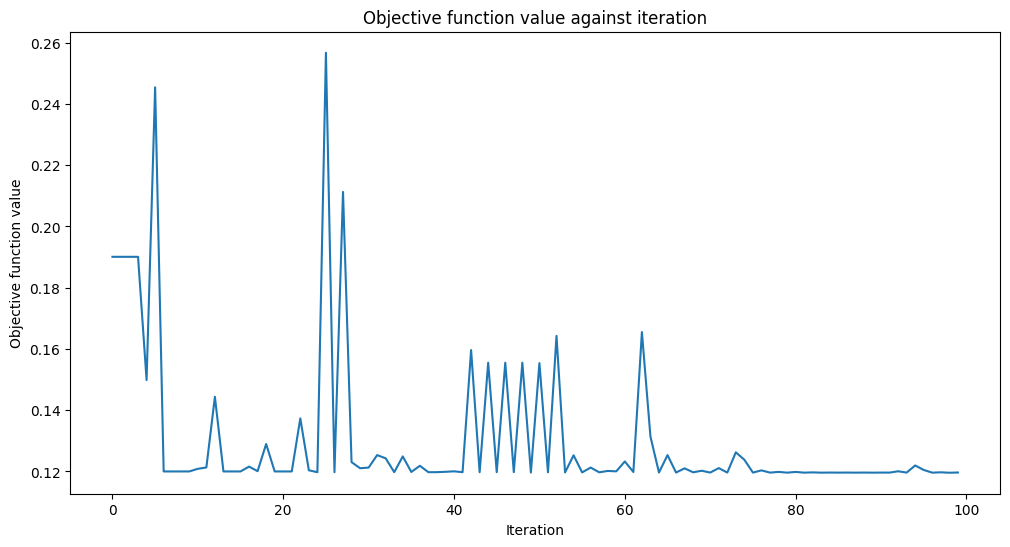

Accuracy on training data: 0.12
Accuracy on test data: 0.12

Sample predictions:
Actual: ham, Predicted: spam
Actual: ham, Predicted: spam
Actual: spam, Predicted: spam
Actual: ham, Predicted: spam
Actual: spam, Predicted: spam
Actual: ham, Predicted: spam
Actual: ham, Predicted: spam
Actual: ham, Predicted: spam
Actual: ham, Predicted: spam
Actual: ham, Predicted: spam


In [43]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit_algorithms.optimizers import COBYLA

import matplotlib.pyplot as plt
from IPython.display import clear_output

class QuantumSpamClassifier:
    def __init__(self, data_path, num_qubits=8, test_size=0.2, random_state=42):
        self.data_path = data_path
        self.num_qubits = num_qubits
        self.test_size = test_size
        self.random_state = random_state
        self.classifier = None
        self.vectorizer = None
        self.scaler = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None

    def load_data(self):
        # Load the dataset
        df = pd.read_csv(self.data_path)
        
        # Prepare the data
        X = df['v2']
        y = df['v1'].map({'ham': 0, 'spam': 1})

        # Split the data
        X_train, X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=self.test_size, random_state=self.random_state
        )

        # Vectorize the text data
        self.vectorizer = CountVectorizer(max_features=1000)
        X_train_vec = self.vectorizer.fit_transform(X_train).toarray()
        X_test_vec = self.vectorizer.transform(X_test).toarray()

        # Scale the features
        self.scaler = StandardScaler()
        self.X_train = self.scaler.fit_transform(X_train_vec)
        self.X_test = self.scaler.transform(X_test_vec)

        # Reduce dimensionality to match number of qubits
        self.X_train = self.X_train[:, :self.num_qubits]
        self.X_test = self.X_test[:, :self.num_qubits]

    def create_circuit(self):
        feature_map = ZZFeatureMap(self.num_qubits)
        ansatz = QuantumCircuit(self.num_qubits)

        # Add some parameterized gates
        params = ParameterVector('θ', length=self.num_qubits * 3)
        for i in range(self.num_qubits):
            ansatz.ry(params[i*3], i)
            ansatz.rz(params[i*3+1], i)
            ansatz.rx(params[i*3+2], i)

        # Add some entanglement
        for i in range(self.num_qubits - 1):
            ansatz.cx(i, i+1)

        # Combine feature map and ansatz
        circuit = QuantumCircuit(self.num_qubits)
        circuit.compose(feature_map, inplace=True)
        circuit.compose(ansatz, inplace=True)

        return circuit, feature_map, ansatz

    def create_classifier(self):
        circuit, feature_map, ansatz = self.create_circuit()

        # Define the observable
        observable = SparsePauliOp.from_list([("Z" * self.num_qubits, 1)])

        # Create the QNN
        qnn = EstimatorQNN(
            circuit=circuit,
            observables=observable,
            input_params=feature_map.parameters,
            weight_params=ansatz.parameters
        )

        # Create the classifier
        initial_point = np.random.random(len(ansatz.parameters))
        self.classifier = NeuralNetworkClassifier(
            qnn,
            optimizer=COBYLA(maxiter=100),
            callback=self.callback_graph,
            initial_point=initial_point
        )

    def train(self):
        self.classifier.fit(self.X_train, self.y_train)

    def evaluate(self):
        train_accuracy = self.classifier.score(self.X_train, self.y_train)
        test_accuracy = self.classifier.score(self.X_test, self.y_test)

        print(f"Accuracy on training data: {train_accuracy:.2f}")
        print(f"Accuracy on test data: {test_accuracy:.2f}")

        y_pred = self.classifier.predict(self.X_test)

        print("\nSample predictions:")
        for actual, pred in zip(self.y_test[:10], y_pred[:10]):
            print(f"Actual: {'spam' if actual else 'ham'}, Predicted: {'spam' if pred else 'ham'}")

    @staticmethod
    def callback_graph(weights, obj_func_eval):
        clear_output(wait=True)
        QuantumSpamClassifier.objective_func_vals.append(obj_func_eval)
        plt.title("Objective function value against iteration")
        plt.xlabel("Iteration")
        plt.ylabel("Objective function value")
        plt.plot(range(len(QuantumSpamClassifier.objective_func_vals)), QuantumSpamClassifier.objective_func_vals)
        plt.show()

    objective_func_vals = []

# Usage example
if __name__ == "__main__":
    # Set up matplotlib for inline plotting
    plt.rcParams["figure.figsize"] = (12, 6)

    # Path to your dataset (CSV file with 'text' and 'label' columns)
    data_path = 'spam_utf8.csv'

    # Create an instance of the classifier
    qsc = QuantumSpamClassifier(data_path=data_path)

    # Load and preprocess the data
    qsc.load_data()

    # Create the quantum circuit and classifier
    qsc.create_classifier()

    # Train the classifier
    qsc.train()

    # Evaluate the classifier
    qsc.evaluate()

In [8]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader

# Load the dataset
df = pd.read_csv('spam.csv', encoding='latin-1')
df = df[['v1', 'v2']]  # Only keep necessary columns
df.columns = ['label', 'text']  # Rename columns for easier access

ham_count=0
spam_count=0
for i in  df['label']:
    if i =="ham":ham_count+=1
    if i =="spam":spam_count+=1

print(spam_count,ham_count)

# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])


747 4825


In [2]:
# Vectorize the text data
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(df['text']).toarray()
y = df['label'].values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [3]:
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = torch.tensor(texts, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

train_dataset = TextDataset(X_train, y_train)
test_dataset = TextDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [4]:
class SpamClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SpamClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

input_dim = X_train.shape[1]
hidden_dim = 128
output_dim = 2

model = SpamClassifier(input_dim, hidden_dim, output_dim)


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
n_epochs = 5

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for texts, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')


Epoch 1, Loss: 0.2618943679412561
Epoch 2, Loss: 0.0469929447863251
Epoch 3, Loss: 0.026799482250187013
Epoch 4, Loss: 0.01663228782958218
Epoch 5, Loss: 0.012037402035535447


In [6]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for texts, labels in test_loader:
        outputs = model(texts)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total}%')


Accuracy: 97.9372197309417%


Feature Map Circuit:


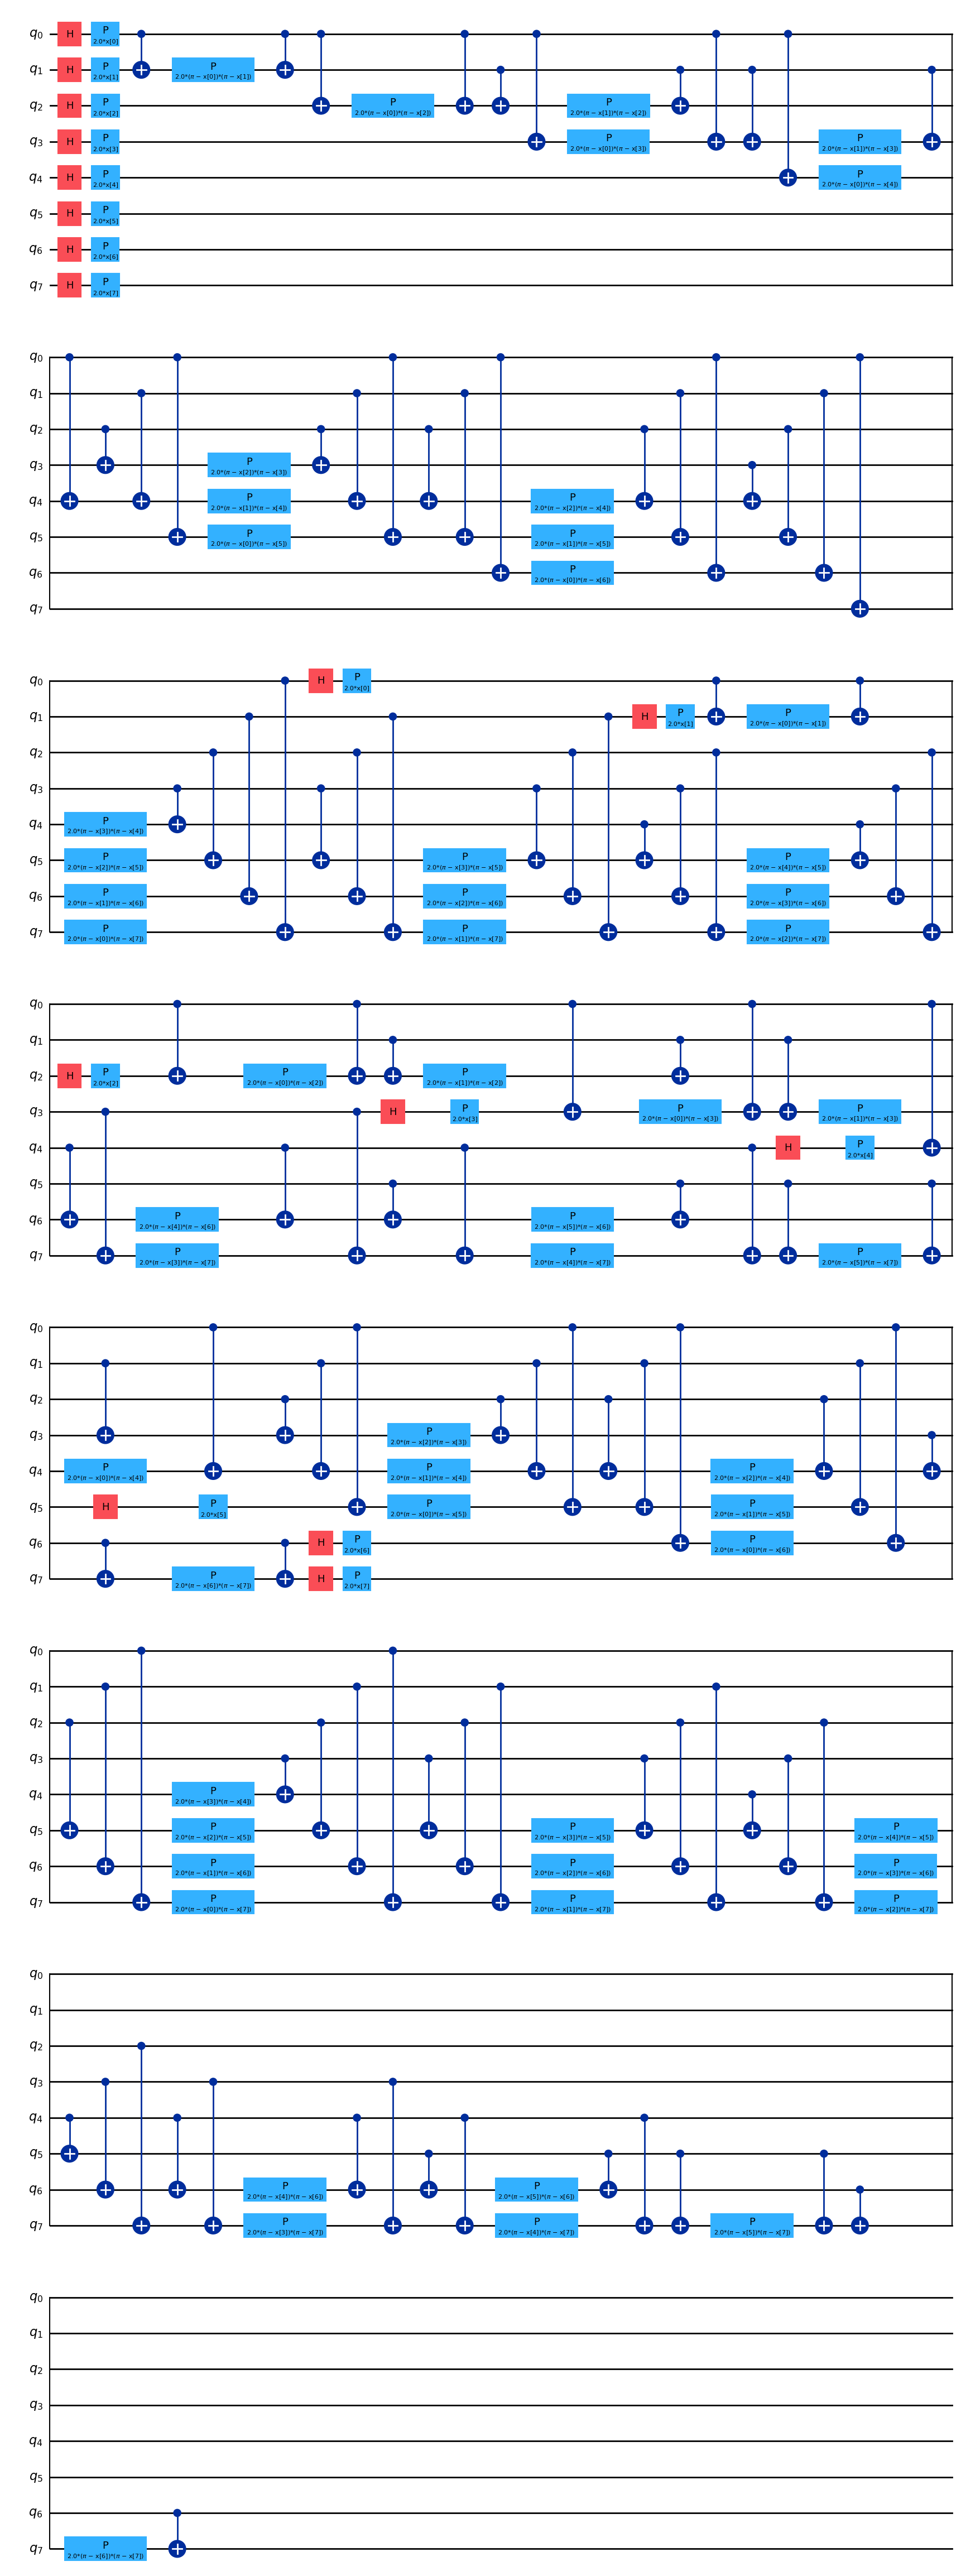

Ansatz Circuit:


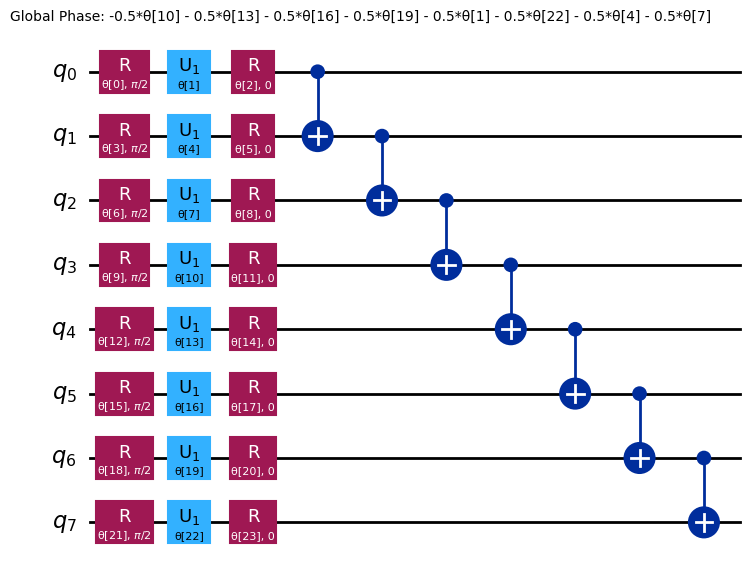

Combined Circuit:


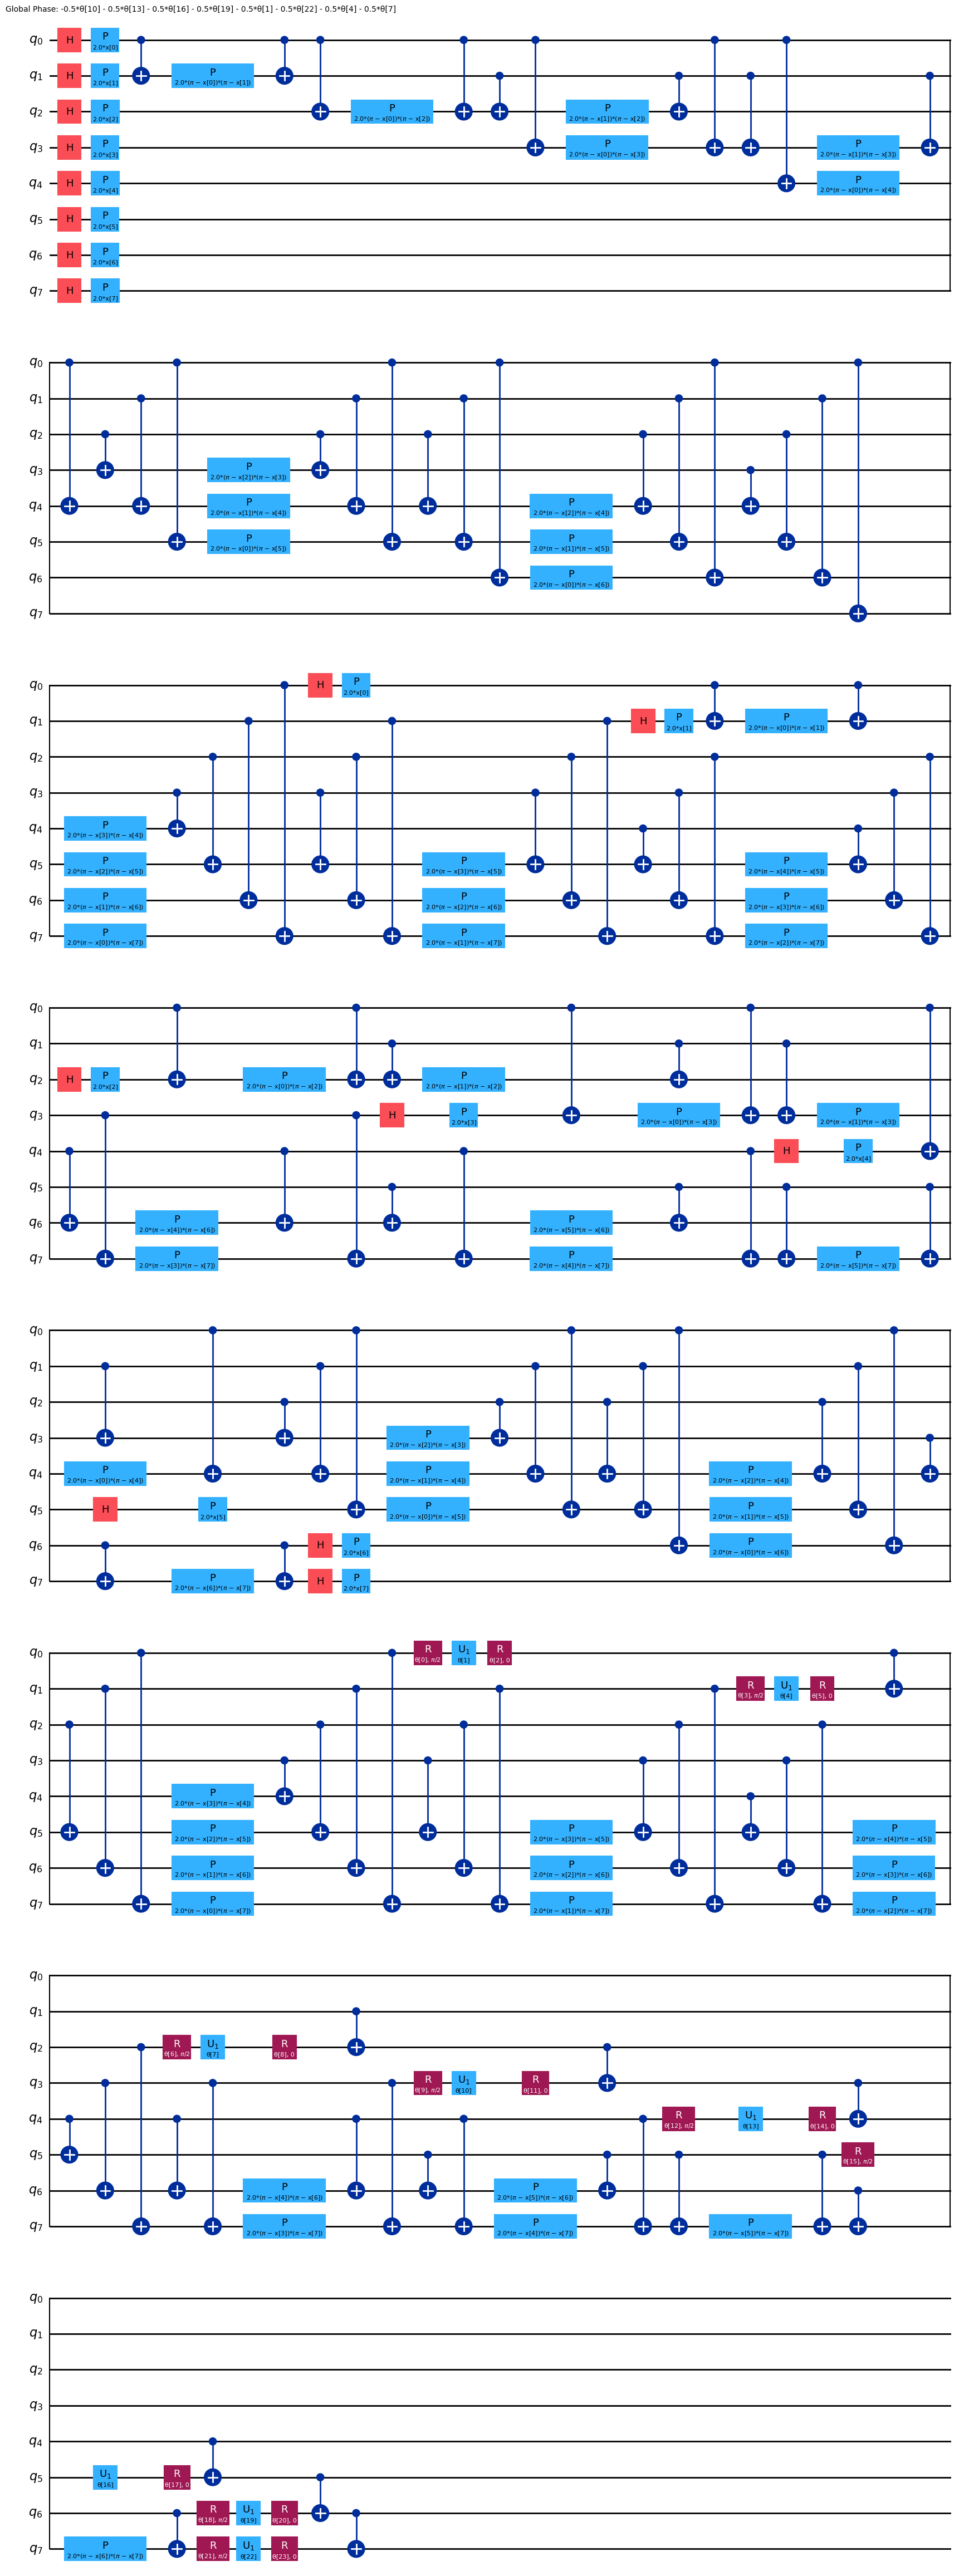

KeyboardInterrupt: 

In [11]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit_algorithms.optimizers import COBYLA

import matplotlib.pyplot as plt
from IPython.display import clear_output

class QuantumSpamClassifier:
    def __init__(self, data_path, num_qubits=8, test_size=0.2, random_state=42):
        self.data_path = data_path
        self.num_qubits = num_qubits
        self.test_size = test_size
        self.random_state = random_state
        self.classifier = None
        self.vectorizer = None
        self.scaler = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None

    def load_data(self):
        # Load the dataset
        df = pd.read_csv(self.data_path)
        
        # Prepare the data
        X = df['v2']
        y = df['v1'].map({'ham': 0, 'spam': 1})

        # Split the data
        X_train, X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=self.test_size, random_state=self.random_state
        )

        # Vectorize the text data
        self.vectorizer = CountVectorizer(max_features=1000)
        X_train_vec = self.vectorizer.fit_transform(X_train).toarray()
        X_test_vec = self.vectorizer.transform(X_test).toarray()

        # Scale the features
        self.scaler = StandardScaler()
        self.X_train = self.scaler.fit_transform(X_train_vec)
        self.X_test = self.scaler.transform(X_test_vec)

        # Reduce dimensionality to match number of qubits
        self.X_train = self.X_train[:, :self.num_qubits]
        self.X_test = self.X_test[:, :self.num_qubits]

    def create_circuit(self):
        feature_map = ZZFeatureMap(self.num_qubits)
        ansatz = QuantumCircuit(self.num_qubits)

        # Add some parameterized gates
        params = ParameterVector('θ', length=self.num_qubits * 3)
        for i in range(self.num_qubits):
            ansatz.ry(params[i*3], i)
            ansatz.rz(params[i*3+1], i)
            ansatz.rx(params[i*3+2], i)

        # Add some entanglement
        for i in range(self.num_qubits - 1):
            ansatz.cx(i, i+1)

        # Combine feature map and ansatz
        circuit = QuantumCircuit(self.num_qubits)
        circuit.compose(feature_map, inplace=True)
        circuit.compose(ansatz, inplace=True)

        return circuit, feature_map, ansatz

    def create_classifier(self):
        circuit, feature_map, ansatz = self.create_circuit()

        # Define the observable
        observable = SparsePauliOp.from_list([("Z" * self.num_qubits, 1)])

        # Create the QNN
        qnn = EstimatorQNN(
            circuit=circuit,
            observables=observable,
            input_params=feature_map.parameters,
            weight_params=ansatz.parameters
        )

        # Create the classifier
        initial_point = np.random.random(len(ansatz.parameters))
        self.classifier = NeuralNetworkClassifier(
            qnn,
            optimizer=COBYLA(maxiter=100),
            callback=self.callback_graph,
            initial_point=initial_point
        )

        # Draw the circuits
        self.draw_circuits(circuit, feature_map, ansatz)

    def train(self):
        self.classifier.fit(self.X_train, self.y_train)

    def evaluate(self):
        train_accuracy = self.classifier.score(self.X_train, self.y_train)
        test_accuracy = self.classifier.score(self.X_test, self.y_test)

        print(f"Accuracy on training data: {train_accuracy:.2f}")
        print(f"Accuracy on test data: {test_accuracy:.2f}")

        y_pred = self.classifier.predict(self.X_test)

        print("\nSample predictions:")
        for actual, pred in zip(self.y_test[:10], y_pred[:10]):
            print(f"Actual: {'spam' if actual else 'ham'}, Predicted: {'spam' if pred else 'ham'}")

    @staticmethod
    def callback_graph(weights, obj_func_eval):
        clear_output(wait=True)
        QuantumSpamClassifier.objective_func_vals.append(obj_func_eval)
        plt.title("Objective function value against iteration")
        plt.xlabel("Iteration")
        plt.ylabel("Objective function value")
        plt.plot(range(len(QuantumSpamClassifier.objective_func_vals)), QuantumSpamClassifier.objective_func_vals)
        plt.show()

    def draw_circuits(self, circuit, feature_map, ansatz):
        # Draw the feature map circuit
        print("Feature Map Circuit:")
        display(feature_map.decompose().draw(output='mpl'))

        # Draw the ansatz circuit
        print("Ansatz Circuit:")
        display(ansatz.decompose().draw(output='mpl'))

        # Draw the combined circuit
        print("Combined Circuit:")
        display(circuit.decompose().draw(output='mpl'))

    objective_func_vals = []

# Usage example
if __name__ == "__main__":
    # Set up matplotlib for inline plotting
    plt.rcParams["figure.figsize"] = (12, 6)

    # Path to your dataset (CSV file with 'text' and 'label' columns)
    data_path = 'spam_utf8.csv'

    # Create an instance of the classifier
    qsc = QuantumSpamClassifier(data_path=data_path)

    # Load and preprocess the data
    qsc.load_data()

    # Create the quantum circuit and classifier
    qsc.create_classifier()

    # Train the classifier
    qsc.train()

    # Evaluate the classifier
    qsc.evaluate()
